# <div class="alert alert-warning" style="background-color: #FF8C69; color: #89628a;"> <center><font color="red">**Desempenho do modelo Árvore de Decisão**</font></center>
<center>Autoras: Luiza Davoli, Samarah L. M. Ramos e Sarah S. Silva</center>
<center>˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .˚ · • . ° .</center>
 

## Introdução
Árvores de decisão são modelos de aprendizado de máquina que realizam escolhas binárias com base em uma hierárquia, formando um mapa que se assemelha com uma árvore, por isso o nome. Esse tipo de modelo, permite explicar as decisões, identificar possíveis trajetos e determinar qual seria a melhor alternativa. Eles começam por uma raiz, que não possui ramificação de entrada, depois segue para um dos nós de decisão até que chegue em um nó folha, que é um evento final, eles são os resultados possíveis dentro do conjunto de dados, dessa forma, essa estrutura permite uma melhor compreensão de como uma decisão foi tomada. 

Modelos de árvore de decisão repetem de maneira descendente e recursiva o processo de divisão dos dados até que todos tenham sido rotulados. Devido a isso, árvores muito grandes (com maior profundidade) podem ter dificuldade de rotular os dados em cada categoria, o que pode causar fragmentação de dados e até mesmo sobreajuste, assim, árvores menores são mais recomendadas pelo seu menor nível de complexidade.

### Importações necessárias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import OneHotEncoder

### Pré definido

In [2]:
SEMENTE_ALEATORIA_TESTE = 18
SEMENTE_ALEATORIA_VAL = 1001
SEMENTE_ALEATORIA_MODELO = 7
NUM_FOLDS = 3
NUM_TRIALS = 100

* SEMENTE_ALEATORIA: Garante reprodutibilidade dos resultados.
* NUM_FOLDS: Número de folds para validação cruzada.
* NUM_TRIALS: Número de tentativas para otimização com Optuna.

### Lê o data frame

In [3]:
df = pd.read_csv("dados_tratados.csv")
print(f"Dataset shape: {df.shape}")
print(f"Primeiras 5 linhas:")
print(df.head())

Dataset shape: (705, 13)
Primeiras 5 linhas:
   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_

Esse é o data frame escolhido para o estudo já tratado com as etapas decritas no git.

### Separando variáveis numéricas e categóricas

In [4]:
# Separando variáveis numéricas e categóricas.
numericos = df[["Age", 
                "Avg_Daily_Usage_Hours", 
                "Sleep_Hours_Per_Night", 
                "Conflicts_Over_Social_Media", 
                "Addicted_Score"]].values

categoricos = df[["Gender",
                  "Academic_Level",
                 "Country", 
                 "Most_Used_Platform",
                 "Affects_Academic_Performance",
                 "Relationship_Status"]].values

# Transformação categórico-numérica.
encoder = OneHotEncoder(sparse_output=False, drop='first')

categ_encoded = encoder.fit_transform(categoricos)

X = np.hstack([numericos, categ_encoded])

y = df["Mental_Health_Score"].values

**Estrutura dos dados:**  
- Variáveis numéricas: Age, Avg_Daily_Usage_Hours, Sleep_Hours_Per_Night, etc.
- Variáveis categóricas: Gender, Academic_Level, Country, etc.
- Target: Mental_Health_Score (variável contínua → regressão).

### Divisão dos Dados

In [5]:
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=SEMENTE_ALEATORIA_TESTE  
)

X_treino_, X_val, y_treino_, y_val = train_test_split(
    X_treino, y_treino, test_size=0.1, random_state=SEMENTE_ALEATORIA_VAL 
)

**Estratégia de divisão:**
- Treino (72%): Para treinar do modelo
- Validação (8%): Dados para ajustar hiperparâmetros
- Teste (20%): Avalia o modelo final

In [6]:
# Verifique se não há overlap entre treino, teste e validação
print(f"Tamanho do dataset: {len(X)}")
print(f"Tamanho do treino: {len(X_treino_)}")
print(f"Tamanho do teste: {len(X_teste)}")
print(f"Tamanho do validação: {len(X_val)}")
print(f"Soma treino + teste + validação: {len(X_treino_) + len(X_teste) + len(X_val)}")

Tamanho do dataset: 705
Tamanho do treino: 507
Tamanho do teste: 141
Tamanho do validação: 57
Soma treino + teste + validação: 705


### Função de Otimização com Optuna

In [7]:
def objetivo_AD(trial):

    # Cria cópias temporárias para não alterar os dados originais.
    X_temp, y_temp = X_treino_, y_treino_
    
    parametros = {
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error']),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    
    modelo = DecisionTreeRegressor(**parametros, random_state=SEMENTE_ALEATORIA_MODELO)
    score = cross_val_score(modelo, X_temp, y_temp,
                             cv=NUM_FOLDS,
                             scoring='neg_mean_squared_error',
                             n_jobs=-1).mean()
    
    return score

**Hiperparâmetros otimizados:**
- criterion: critério para medir a qualidade das divisões (erro quadrático, erro absoluto, etc.);
- max_depth: Profundidade máxima da árvore;
- min_samples_split: Mínimo de amostras para dividir um nó;
- min_samples_leaf: Mínimo de amostras nas folhas finais;
- max_features: Quantos atributos considerar em cada split.

### Otimização com Optuna

In [8]:
study = optuna.create_study(direction='maximize') 
study.optimize(objetivo_AD, n_trials=NUM_TRIALS)

print("\nMelhores hiperparâmetros:")
print(study.best_params)
print(f"Melhor MAE negativo: {study.best_value:.4f}")

[I 2025-11-03 21:01:42,713] A new study created in memory with name: no-name-43f7f9b2-b8f6-425d-83f5-245c43a59d58
[I 2025-11-03 21:01:53,653] Trial 0 finished with value: -0.8336803471548078 and parameters: {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: -0.8336803471548078.
[I 2025-11-03 21:02:07,754] Trial 1 finished with value: -0.8274991274612665 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: -0.8274991274612665.
[I 2025-11-03 21:02:20,783] Trial 2 finished with value: -1.15722634296399 and parameters: {'criterion': 'friedman_mse', 'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 1 with value: -0.8274991274612665.
[I 2025-11-03 21:02:29,956] Trial 3 finished with value: -0.9064787479813153 and parameters: {'criterio


Melhores hiperparâmetros:
{'criterion': 'friedman_mse', 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None}
Melhor MAE negativo: -0.0396


Esse processo testa 100 combinações diferentes de hiperparâmetros e usa validação cruzada para evitar overfitting de um forma que maximiza neg_mean_absolute_error (equivale a minimizar MAE).

### Treinamento e Previsão do Modelo Final

In [9]:
best_params = study.best_params
modelo_final = DecisionTreeRegressor(**best_params, random_state=SEMENTE_ALEATORIA_MODELO) 
modelo_final.fit(X_treino_, y_treino_)

y_val_pred = modelo_final.predict(X_val)

O treinamento é feito com os melhores hiperparâmetros encontrados em 100 tentativas.

### Avaliação do Modelo

In [10]:
MSE_val = mean_squared_error(y_val, y_val_pred)
MAE_val = mean_absolute_error(y_val, y_val_pred)
RMSE_val = np.sqrt(MSE_val)

print("Desempenho na validação")
print(f"MSE: {MSE_val:.4f}")
print(f"MAE: {MAE_val:.4f}")
print(f"RMSE: {RMSE_val:.4f}")

Desempenho na validação
MSE: 0.0300
MAE: 0.0452
RMSE: 0.1733


In [11]:
y_teste_pred = modelo_final.predict(X_teste)

print("Desempenho do conjunto de teste")
print(f"MSE: {mean_squared_error(y_teste, y_teste_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_teste, y_teste_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_teste, y_teste_pred)):.4f}")

Desempenho do conjunto de teste
MSE: 0.0390
MAE: 0.0437
RMSE: 0.1974


**Métricas usadas:**
- MSE (Mean Squared Error): Penaliza mais erros grandes
- MAE (Mean Absolute Error): Interpretação mais direta
- RMSE (Root Mean Squared Error): Mais fácil de visualizar por estar na mesma unidade do target

### Gráfico de dispersão: Valores Reais vs Preditos

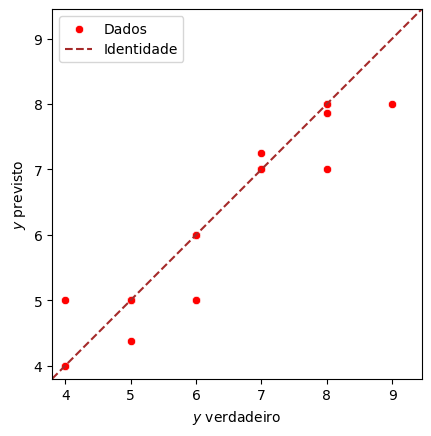

In [12]:
# definindo os valores máximos e mínimos dos eixos do gráfico
min_val = min(y_teste.min(), y_teste_pred.min())
max_val = max(y_teste.max(), y_teste_pred.max())
intervalo = [min_val * 0.95, max_val * 1.05]
 
# plotando o gráfico
eixo = sns.scatterplot(x=y_teste, y=y_teste_pred, label="Dados", color="red")
eixo.plot(intervalo, intervalo, "--", label="Identidade", color="brown")
eixo.set(
    xlabel="$y$ verdadeiro",
    ylabel="$y$ previsto",
    xlim=intervalo,
    ylim=intervalo,
    aspect="equal",
)
eixo.legend()

**Interpretação:** A dispersão em geral tem pontos próximos à linha vermelha o que indica boas previsões, todavia fica visível que os pontos com notas mais altas não são tão comuns o que indica que o modelo está subestimando os resultados.

In [13]:
MSE_teste = mean_squared_error(y_teste, y_teste_pred)
RMSE_teste = root_mean_squared_error(y_teste, y_teste_pred)
print("Resumo")
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"MSE no teste: {MSE_teste:.4f}")
print(f"RMSE no teste: {RMSE_teste:.4f}")
print(f"Número de features: {X_treino.shape[1]}")

Resumo
Melhores hiperparâmetros: {'criterion': 'friedman_mse', 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None}
MSE no teste: 0.0390
RMSE no teste: 0.1974
Número de features: 131


### Importância das Features

In [14]:
importancias = modelo_final.feature_importances_

feature_names = (['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 
                  'Conflicts_Over_Social_Media', 'Addicted_Score'] + 
                 list(encoder.get_feature_names_out(['Academic_Level', 'Country', 'Gender',
                                                   'Most_Used_Platform',
                                                   'Affects_Academic_Performance',
                                                   'Relationship_Status'])))
df_importancias = pd.DataFrame({
    'feature': feature_names,
    'importance': importancias
}).sort_values('importance', ascending=False)

print("\nTop 10 features mais importantes:")
print(df_importancias.head(10))


Top 10 features mais importantes:
                        feature  importance
4                Addicted_Score    0.904533
66              Gender_Maldives    0.018470
96           Gender_South Korea    0.017139
73                 Gender_Nepal    0.012623
2         Sleep_Hours_Per_Night    0.012080
80              Gender_Pakistan    0.009633
17            Gender_Bangladesh    0.007466
51                 Gender_Italy    0.005016
3   Conflicts_Over_Social_Media    0.004949
1         Avg_Daily_Usage_Hours    0.004591


### Plotar as 15 features mais importantes

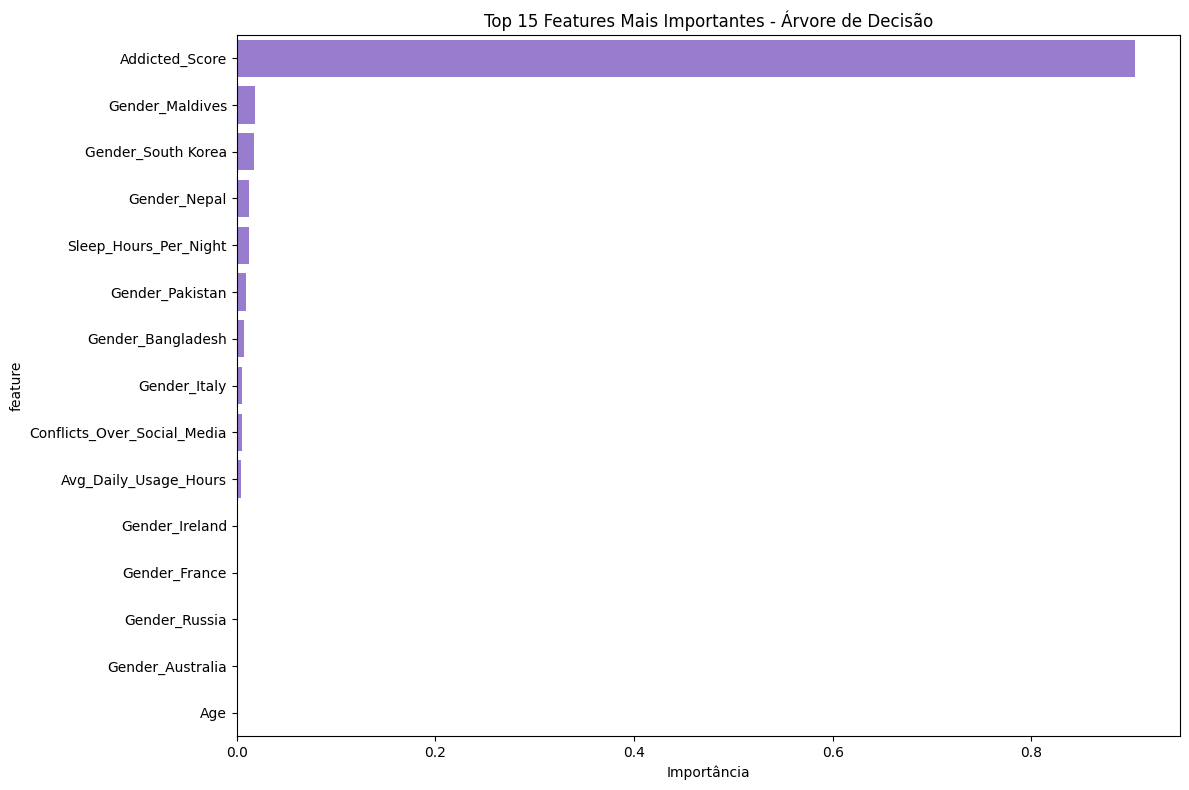

In [15]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df_importancias.head(15), x='importance', y='feature', color="#9370db")
plt.title('Top 15 Features Mais Importantes - Árvore de Decisão')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

### Plot da Árvore de Decisão

In [16]:
atributos_categoricos = ["Gender", "Academic_Level", "Country", 
                    "Most_Used_Platform", "Affects_Academic_Performance", 
                    "Relationship_Status"]

atributos_numericos = ["Gender",
                       "Academic_Level",
                       "Country", 
                       "Most_Used_Platform",
                       "Affects_Academic_Performance",
                       "Relationship_Status"]

encoded_feature_names = encoder.get_feature_names_out(atributos_categoricos)

atributos_nomes = encoded_feature_names
atributos_nomes

array(['Gender_Male', 'Academic_Level_High School',
       'Academic_Level_Undergraduate', 'Country_Albania',
       'Country_Andorra', 'Country_Argentina', 'Country_Armenia',
       'Country_Australia', 'Country_Austria', 'Country_Azerbaijan',
       'Country_Bahamas', 'Country_Bahrain', 'Country_Bangladesh',
       'Country_Belarus', 'Country_Belgium', 'Country_Bhutan',
       'Country_Bolivia', 'Country_Bosnia', 'Country_Brazil',
       'Country_Bulgaria', 'Country_Canada', 'Country_Chile',
       'Country_China', 'Country_Colombia', 'Country_Costa Rica',
       'Country_Croatia', 'Country_Cyprus', 'Country_Czech Republic',
       'Country_Denmark', 'Country_Ecuador', 'Country_Egypt',
       'Country_Estonia', 'Country_Finland', 'Country_France',
       'Country_Georgia', 'Country_Germany', 'Country_Ghana',
       'Country_Greece', 'Country_Hong Kong', 'Country_Hungary',
       'Country_Iceland', 'Country_India', 'Country_Indonesia',
       'Country_Iraq', 'Country_Ireland', 'Countr

In [17]:
atributos_nomes = ["Gender", "Academic_Level", "Country", 
                   "Most_Used_Platform", "Affects_Academic_Performance",
                   "Relationship_Status", 'Gender_Male', 'Academic_Level_High School',
                   'Academic_Level_Undergraduate', 'Country_Albania',
                   'Country_Andorra', 'Country_Argentina', 'Country_Armenia',
                   'Country_Australia', 'Country_Austria', 'Country_Azerbaijan',
                   'Country_Bahamas', 'Country_Bahrain', 'Country_Bangladesh',
                   'Country_Belarus', 'Country_Belgium', 'Country_Bhutan',
                   'Country_Bolivia', 'Country_Bosnia', 'Country_Brazil',
                   'Country_Bulgaria', 'Country_Canada', 'Country_Chile',
                   'Country_China', 'Country_Colombia', 'Country_Costa Rica',
                   'Country_Croatia', 'Country_Cyprus', 'Country_Czech Republic',
                   'Country_Denmark', 'Country_Ecuador', 'Country_Egypt',
                   'Country_Estonia', 'Country_Finland', 'Country_France',
                   'Country_Georgia', 'Country_Germany', 'Country_Ghana',
                   'Country_Greece', 'Country_Hong Kong', 'Country_Hungary',
                   'Country_Iceland', 'Country_India', 'Country_Indonesia',
                   'Country_Iraq', 'Country_Ireland', 'Country_Israel',
                   'Country_Italy', 'Country_Jamaica', 'Country_Japan',
                   'Country_Jordan', 'Country_Kazakhstan', 'Country_Kenya',
                   'Country_Kosovo', 'Country_Kuwait', 'Country_Kyrgyzstan',
                   'Country_Latvia', 'Country_Lebanon', 'Country_Liechtenstein',
                   'Country_Lithuania', 'Country_Luxembourg', 'Country_Malaysia',
                   'Country_Maldives', 'Country_Malta', 'Country_Mexico',
                   'Country_Moldova', 'Country_Monaco', 'Country_Montenegro',
                   'Country_Morocco', 'Country_Nepal', 'Country_Netherlands',
                   'Country_New Zealand', 'Country_Nigeria',
                   'Country_North Macedonia', 'Country_Norway', 'Country_Oman',
                   'Country_Pakistan', 'Country_Panama', 'Country_Paraguay',
                   'Country_Peru', 'Country_Philippines', 'Country_Poland',
                   'Country_Portugal', 'Country_Qatar', 'Country_Romania',
                   'Country_Russia', 'Country_San Marino', 'Country_Serbia',
                   'Country_Singapore', 'Country_Slovakia', 'Country_Slovenia',
                   'Country_South Africa', 'Country_South Korea', 'Country_Spain',
                   'Country_Sri Lanka', 'Country_Sweden', 'Country_Switzerland',
                   'Country_Syria', 'Country_Taiwan', 'Country_Tajikistan',
                   'Country_Thailand', 'Country_Trinidad', 'Country_Turkey',
                   'Country_UAE', 'Country_UK', 'Country_USA', 'Country_Ukraine',
                   'Country_Uruguay', 'Country_Uzbekistan', 'Country_Vatican City',
                   'Country_Venezuela', 'Country_Vietnam', 'Country_Yemen',
                   'Most_Used_Platform_Instagram', 'Most_Used_Platform_KakaoTalk',
                   'Most_Used_Platform_LINE', 'Most_Used_Platform_LinkedIn',
                   'Most_Used_Platform_Snapchat', 'Most_Used_Platform_TikTok',
                   'Most_Used_Platform_Twitter', 'Most_Used_Platform_VKontakte',
                   'Most_Used_Platform_WeChat', 'Most_Used_Platform_WhatsApp',
                   'Most_Used_Platform_YouTube', 'Affects_Academic_Performance_Yes',
                   'Relationship_Status_In Relationship',
                   'Relationship_Status_Single']

[Text(0.4182692307692308, 0.9444444444444444, 'Affects_Academic_Performance <= 6.5\nsamples = 100.0%\nvalue = 6.18'),
 Text(0.19230769230769232, 0.8333333333333334, 'Affects_Academic_Performance <= 4.5\nsamples = 40.4%\nvalue = 7.28'),
 Text(0.30528846153846156, 0.8888888888888888, 'True  '),
 Text(0.07692307692307693, 0.7222222222222222, 'Country <= 7.05\nsamples = 12.6%\nvalue = 7.95'),
 Text(0.038461538461538464, 0.6111111111111112, 'samples = 0.4%\nvalue = 7.0'),
 Text(0.11538461538461539, 0.6111111111111112, 'Academic_Level <= 4.15\nsamples = 12.2%\nvalue = 7.98'),
 Text(0.07692307692307693, 0.5, 'samples = 10.8%\nvalue = 8.0'),
 Text(0.15384615384615385, 0.5, 'samples = 1.4%\nvalue = 7.86'),
 Text(0.3076923076923077, 0.7222222222222222, 'Country_South Africa <= 0.5\nsamples = 27.8%\nvalue = 6.97'),
 Text(0.2692307692307692, 0.6111111111111112, 'Country_Malaysia <= 0.5\nsamples = 25.8%\nvalue = 7.05'),
 Text(0.23076923076923078, 0.5, 'Country_Armenia <= 0.5\nsamples = 24.9%\nvalue

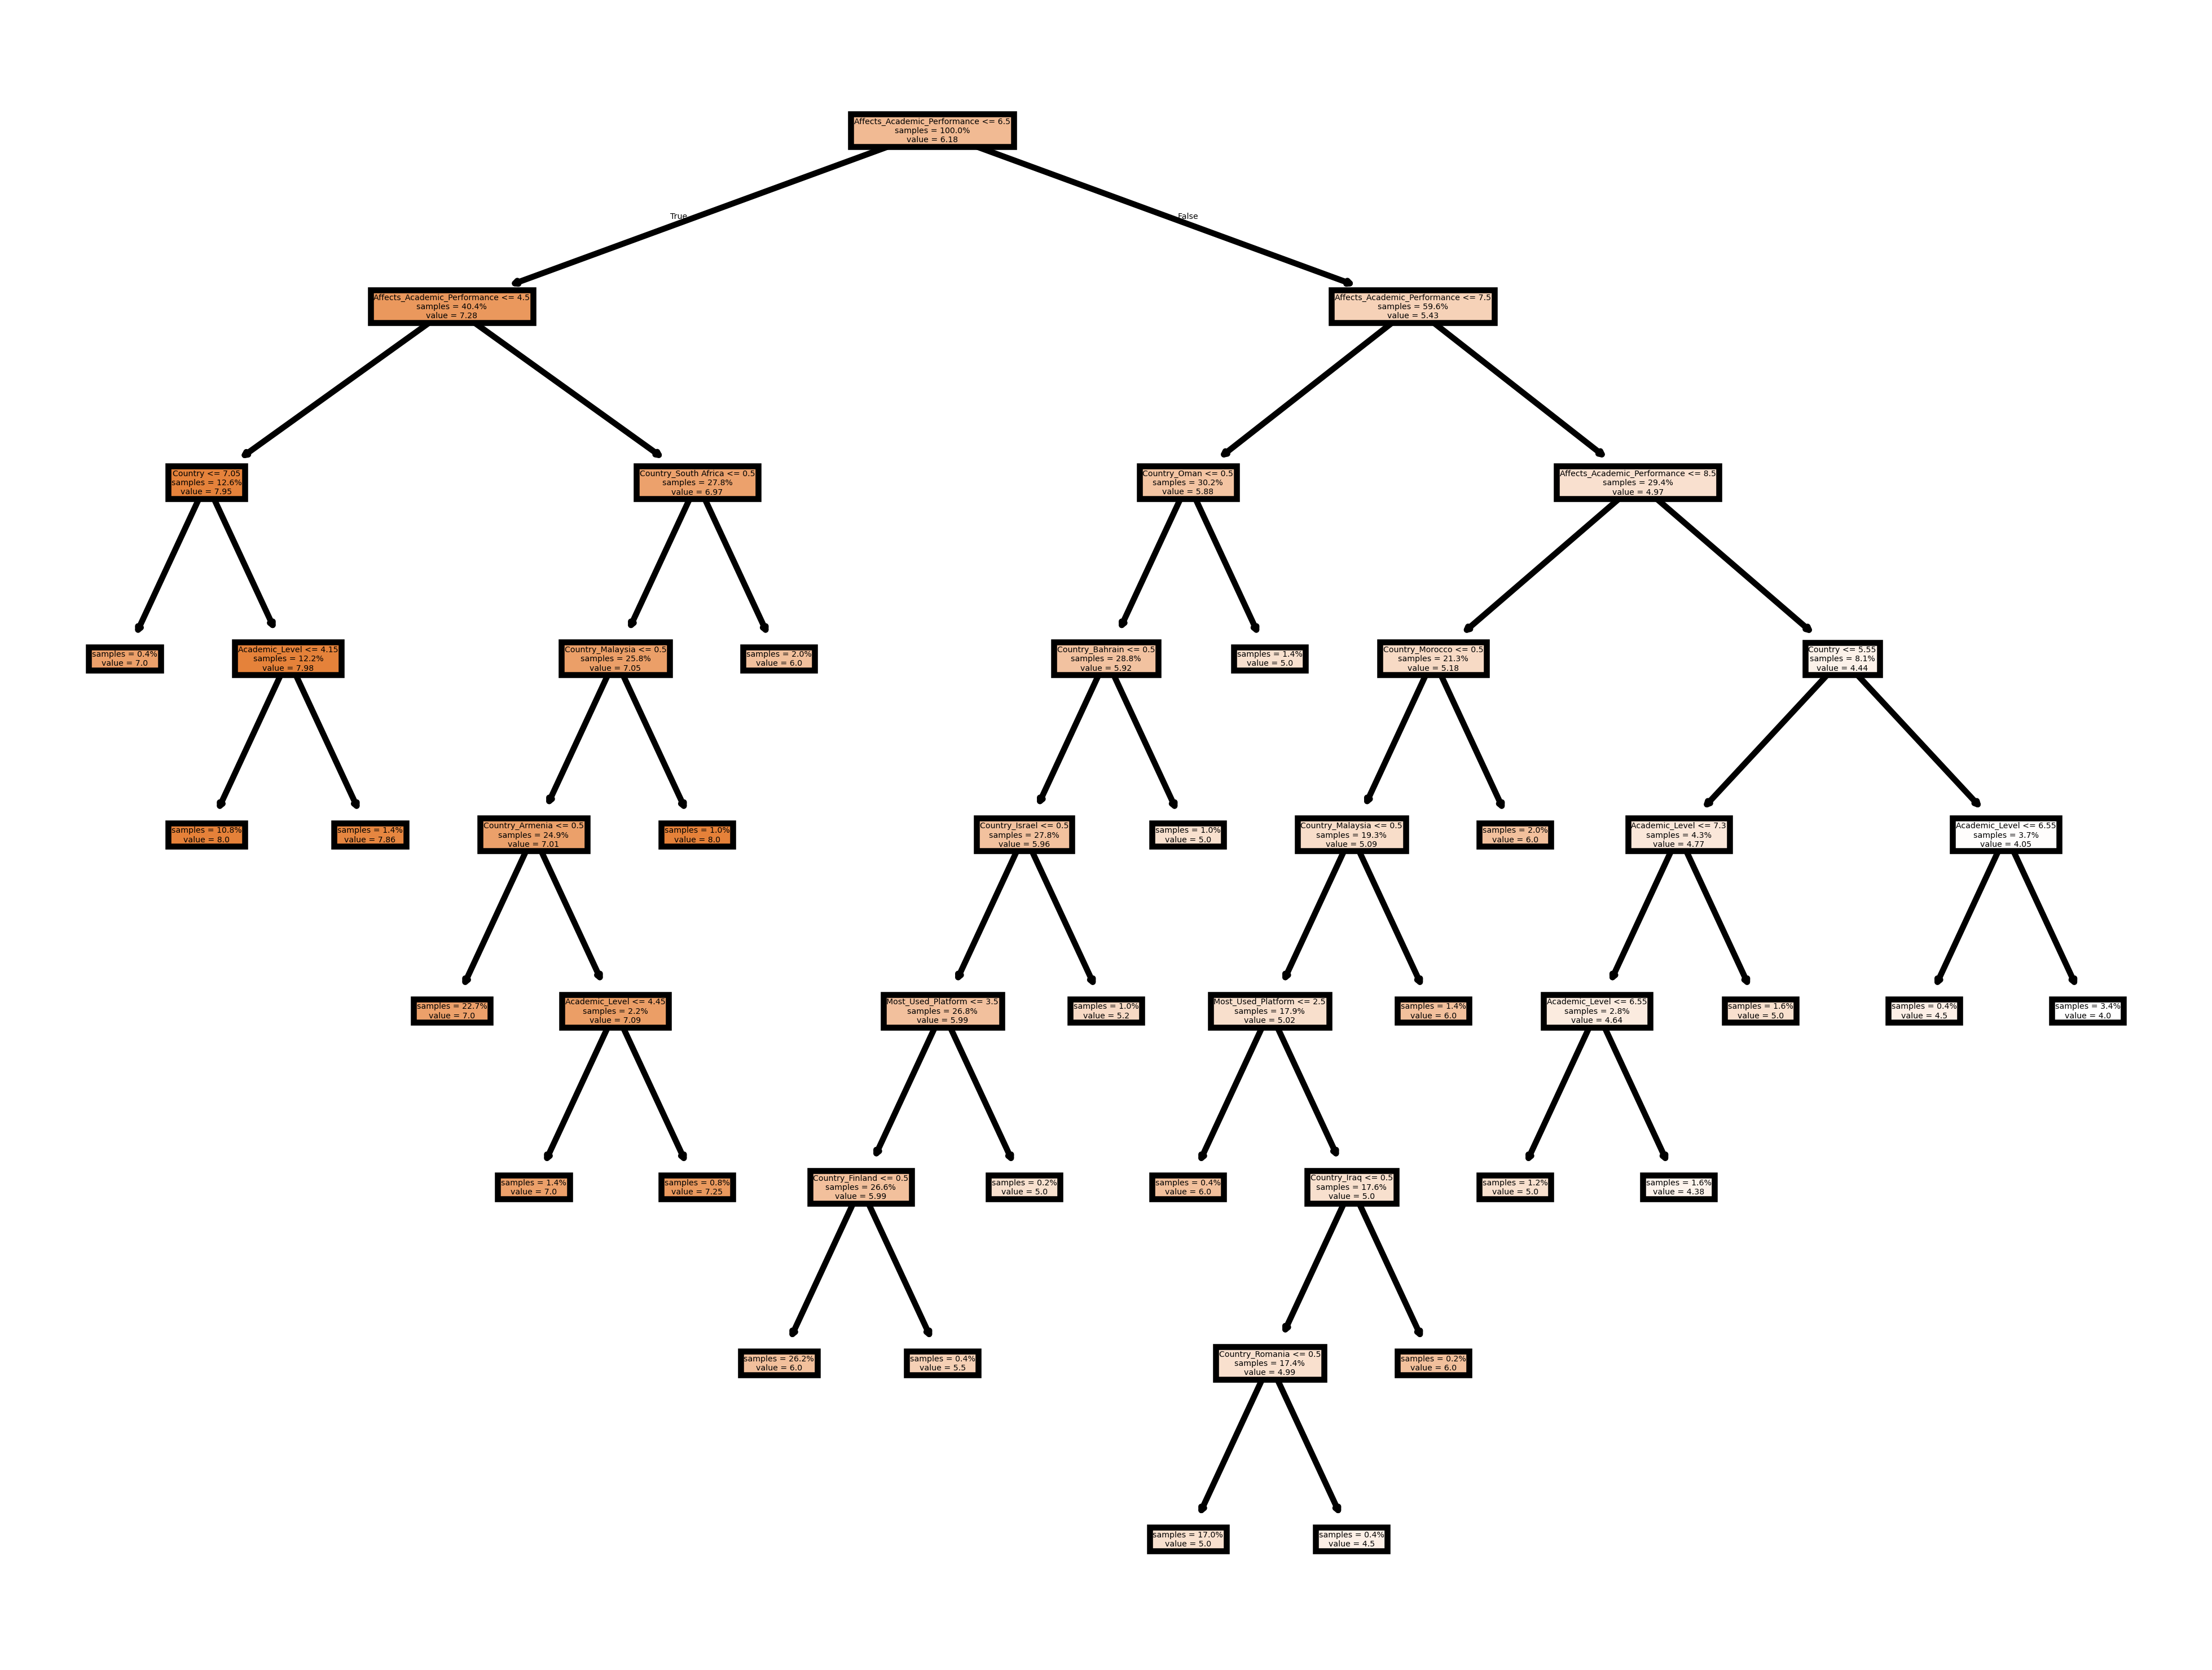

In [18]:
figura, eixo = plt.subplots(dpi=760)

plot_tree(
    modelo_final,
    feature_names=atributos_nomes,
    ax=eixo,
    impurity=False,
    filled=True,
    proportion=True,
    precision=2,
)

## Desempenho e Aplicabilidade do Modelo Árvode de Decisão na Predição de Saúde Mental
O modelo de Árvore de Decisão implementado nesse notebook obteve um bom desempenho, revelando sua capacidade de utilizar as variáveis fornecidas a ele para encontrar o target de saúde mental, com métricas de desempenho consistentes entre os conjuntos de validação e teste. O gráfico de dispersão apresentado demonstra que os dados estão bem distribuídos em torno do valor esperado, características de um modelo não enviesado. Além disso, ele é um modelo mais prático, por não exigir sempre que os dados sejam normalizados, como nesse caso.

## Conclusão
O uso do algoritmo Árvore de Decisão foi eficaz na predição do target e teve seu desempenho otimizado pelo Optuna para que tivesse maior eficiência. Esse modelo pode ser usado para compreender como cada dado foi rotulado e usado para encontrar o score de saúde mental, como no plot da Árvore de Decisão acima. Além disso, esse trabalho também pode ser usado para estudar a relação do uso de redes sociais com o bem estar psicológico e procurar fatores que influênciem positivamente a saúde dos indivíduos.

## Salvando resultados
A fim de combinar os resultados das métricas obtidas em um único notebook, é necessário criar um arquivo que armazene todas essas informações.
 
Nesse caso, o formato utilizado será o JSON (JavaScript Object Notation), que é um formato leve de troca de dados. As vantagens de usar esse formato envolvem sua facilidade de interpretação, tanto para humanos, quanto para máquinas, sua universalidade, já que funciona com qualquer linguagem de programação e sua capacidade de ser aberto em qualquer editor.

In [19]:
import json
from datetime import datetime
import os
 
# Se o arquivo já existe, carregar. Se não, criar novo.
if os.path.exists('model_metrics.json'):
    with open('model_metrics.json', 'r') as f:
        all_models = json.load(f)
else:
    all_models = {}
 
# Adicionar novo modelo (Árvore de Decisão)
all_models['Árvore de Decisão'] = {
    'model_name': 'Árvore de Decisão',
    'mse': float(MSE_teste),
    'rmse': float(RMSE_teste),
    'mse_val': float(MSE_val),
    'rmse_val': float(RMSE_val),
    'timestamp': datetime.now().isoformat(),
    'dataset': 'dados_tratados',
    'target_variable': 'Mental_Health_Score'
}
 
# Salvar atualizado
with open('model_metrics.json', 'w') as f:
    json.dump(all_models, f, indent=4)

## Referências
[1] OPTUNA. **Optuna: A hyperparameter optimization framework**. Disponível em: <https://optuna.org/>.

[2] SCIKIT-LEARN. **sklearn.model_selection.cross_val_score**. Disponível em: <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html>.

[3] SCIKIT-LEARN. **sklearn.tree.DecisionTreeRegressor**. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.

[5] SEABORN. **seaborn: statistical data visualization**. Disponível em: <https://seaborn.pydata.org/>.

[6] SCIKIT-LEARN. **User guide: contents — scikit-learn 0.22.1 documentation**.
Disponível em: <https://scikit-learn.org/stable/user_guide.html>. 

[7] JSON. **JSON**. Disponível em: <https://www.json.org/json-en.html>